### Load required libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

import tensorflow as tf
import keras
from tensorflow.keras import regularizers
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Input
from keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

### Load the data

In [2]:
df = pd.read_csv('./data/creditcard.csv', index_col=0)
print(df.shape)
df.head()

(284807, 30)


,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
Time,,,,,,,,,,,,,,,,,,,,,
0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


#### Data check

In [3]:
df['Class'].value_counts(normalize=True)

0    0.998273
1    0.001727
Name: Class, dtype: float64

In [4]:
df.columns

Index(['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11',
       'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21',
       'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount', 'Class'],
      dtype='object')

In [5]:
df.isnull().values.any()

False

In [6]:
df = df.drop(['Amount'], axis=1)

### Train/test split

In [7]:
frauds = df[df.Class == 1]
#normal = df[df.Class == 0].sample(10000)
normal = df[df.Class == 0]
print("Frauds shape: {}".format(frauds.shape))
print("Normal shape: {}".format(normal.shape))

Frauds shape: (492, 29)
Normal shape: (284315, 29)


In [8]:
data = pd.concat([frauds, normal])
data.shape

(284807, 29)

In [42]:
X_train, X_test = train_test_split(data, test_size=0.3, random_state=42)
X_train = X_train[X_train.Class == 0]
X_train = X_train.drop(['Class'], axis=1)
X_train = X_train.values

X_test, y_test = X_test.drop(['Class'], axis=1).values, X_test['Class'].values

print("X_train shape: {}".format(X_train.shape))
print("X_test shape: {}".format(X_test.shape))

X_train shape: (199013, 28)
X_test shape: (85443, 28)


### Visualize the data with TSNE and PCA

In [10]:
x1 = df[df.Class == 1]
x2 = df[df.Class == 0].sample(10000)

dfd = x1.append(x2)
x = dfd.drop(['Class'], axis=1)
y = dfd['Class'].values

SEED = 42

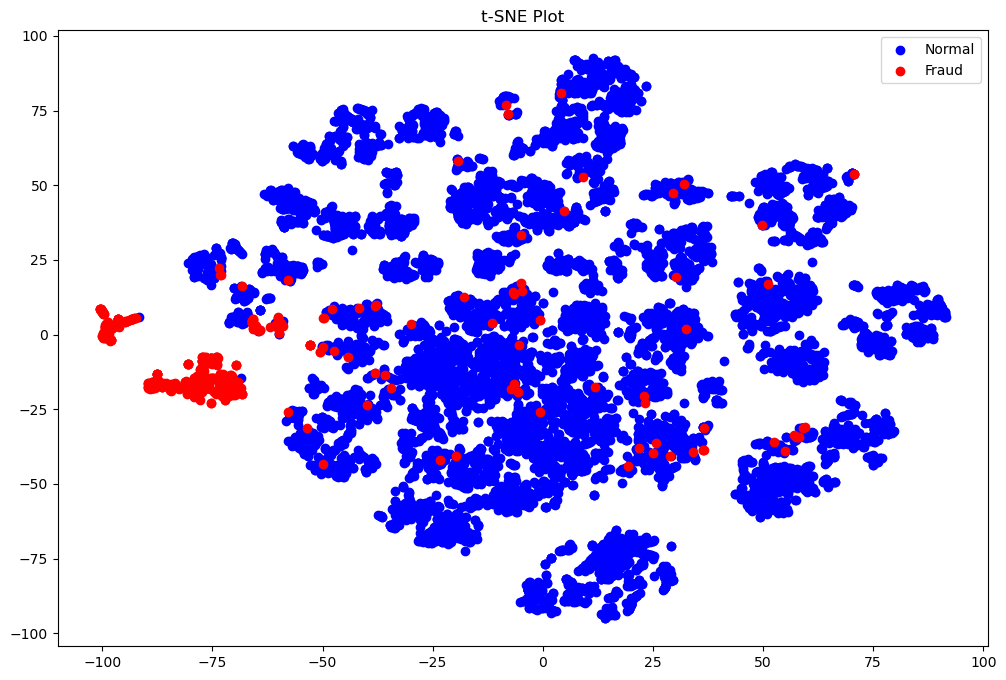

In [11]:
tsne = TSNE(n_components=2, random_state=SEED, init='random', learning_rate=200)
xtsne = tsne.fit_transform(x)
plt.figure(figsize=(12,8));
plt.scatter(xtsne[np.where(y==0), 0], y=xtsne[np.where(y==0), 1], color="blue", label='Normal')
plt.scatter(x=xtsne[np.where(y==1), 0], y=xtsne[np.where(y==1), 1], color="red", label='Fraud')
plt.title('t-SNE Plot')
plt.legend()
plt.show()

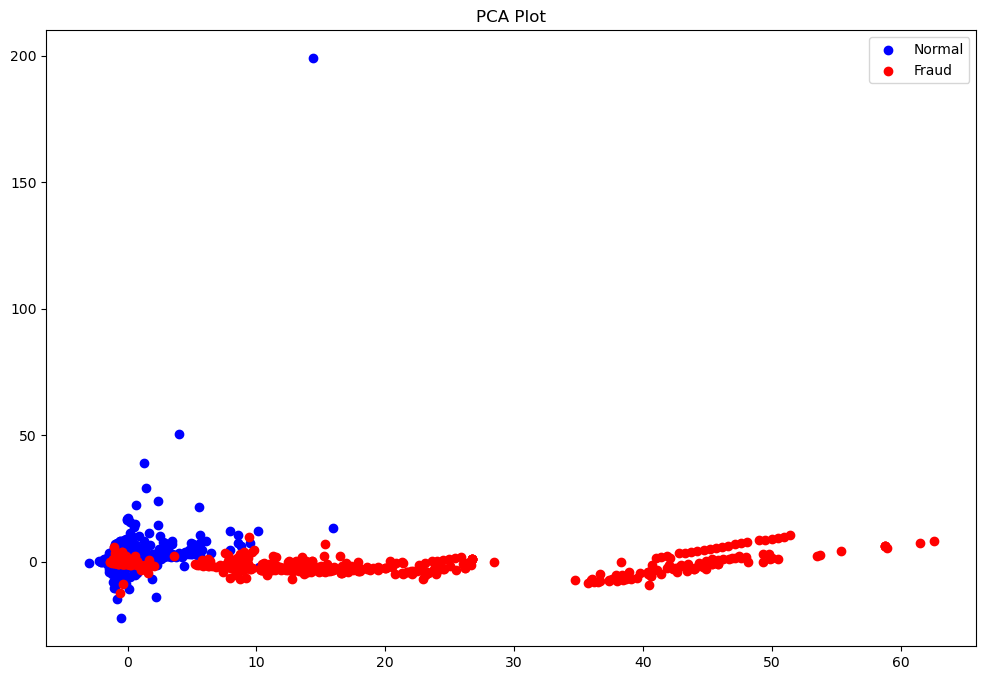

In [12]:
pca = PCA(n_components=2, random_state=SEED)
xpca = pca.fit_transform(x)
plt.figure(figsize=(12,8));
plt.scatter(x=xpca[np.where(y==0), 0], y=xpca[np.where(y==0), 1], color="blue", label='Normal')
plt.scatter(x=xpca[np.where(y==1), 0], y=xpca[np.where(y==1), 1], color="red", label='Fraud')
plt.title('PCA Plot')
plt.legend()
plt.show()

#### Normalize the data

In [13]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

scaler.fit_transform(X_train);
scaler.transform(X_test);

### Sparse AutoEncoder Model(L1)

In [14]:
input_dim = X_train.shape[1]

input_layer = Input(shape=(input_dim, ))
encoder = Dense(40, activation="elu",activity_regularizer=regularizers.l1(10e-5))(input_layer)

encoder = Dense(56, activation="elu",activity_regularizer=regularizers.l1(10e-5))(encoder)

decoder = Dense(40, activation='elu',activity_regularizer=regularizers.l1(10e-5))(encoder)
decoder = Dense(input_dim, activation='elu')(decoder)
sae_L1 = Model(inputs=input_layer, outputs=decoder)

In [15]:
epochs = 100
batch_size = 32
sae_L1.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
checkpointer = ModelCheckpoint(filepath="fraudSpAE_L1.pth", verbose=0, save_best_only=True)

### Training

In [16]:
history = sae_L1.fit(X_train, X_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_split=0.1,
                    callbacks=[checkpointer]).history

Epoch 1/100
5590/5598 [============================>.] - ETA: 0s - loss: 0.2937 - accuracy: 0.8888INFO:tensorflow:Assets written to: fraudSpAE_L1.pth\assets


INFO:tensorflow:Assets written to: fraudSpAE_L1.pth\assets


5598/5598 [==============================] - 25s 4ms/step - loss: 0.2935 - accuracy: 0.8888 - val_loss: 0.2430 - val_accuracy: 0.9223
Epoch 2/100
5586/5598 [============================>.] - ETA: 0s - loss: 0.2630 - accuracy: 0.9193INFO:tensorflow:Assets written to: fraudSpAE_L1.pth\assets


INFO:tensorflow:Assets written to: fraudSpAE_L1.pth\assets


5598/5598 [==============================] - 22s 4ms/step - loss: 0.2630 - accuracy: 0.9194 - val_loss: 0.2351 - val_accuracy: 0.9308
Epoch 3/100
5594/5598 [============================>.] - ETA: 0s - loss: 0.2599 - accuracy: 0.9180INFO:tensorflow:Assets written to: fraudSpAE_L1.pth\assets


INFO:tensorflow:Assets written to: fraudSpAE_L1.pth\assets


5598/5598 [==============================] - 24s 4ms/step - loss: 0.2599 - accuracy: 0.9180 - val_loss: 0.2341 - val_accuracy: 0.9223
Epoch 4/100
5597/5598 [============================>.] - ETA: 0s - loss: 0.2556 - accuracy: 0.9185INFO:tensorflow:Assets written to: fraudSpAE_L1.pth\assets


INFO:tensorflow:Assets written to: fraudSpAE_L1.pth\assets


5598/5598 [==============================] - 25s 5ms/step - loss: 0.2556 - accuracy: 0.9185 - val_loss: 0.2307 - val_accuracy: 0.9274
Epoch 5/100
5598/5598 [==============================] - 22s 4ms/step - loss: 0.2537 - accuracy: 0.9184 - val_loss: 0.2457 - val_accuracy: 0.8976
Epoch 6/100
5595/5598 [============================>.] - ETA: 0s - loss: 0.2525 - accuracy: 0.9166INFO:tensorflow:Assets written to: fraudSpAE_L1.pth\assets


INFO:tensorflow:Assets written to: fraudSpAE_L1.pth\assets


5598/5598 [==============================] - 19s 3ms/step - loss: 0.2524 - accuracy: 0.9166 - val_loss: 0.2288 - val_accuracy: 0.9213
Epoch 7/100
5594/5598 [============================>.] - ETA: 0s - loss: 0.2511 - accuracy: 0.9167INFO:tensorflow:Assets written to: fraudSpAE_L1.pth\assets


INFO:tensorflow:Assets written to: fraudSpAE_L1.pth\assets


5598/5598 [==============================] - 20s 4ms/step - loss: 0.2510 - accuracy: 0.9167 - val_loss: 0.2274 - val_accuracy: 0.9227
Epoch 8/100
5598/5598 [==============================] - 18s 3ms/step - loss: 0.2504 - accuracy: 0.9178 - val_loss: 0.2317 - val_accuracy: 0.9150
Epoch 9/100
5598/5598 [==============================] - ETA: 0s - loss: 0.2491 - accuracy: 0.9202INFO:tensorflow:Assets written to: fraudSpAE_L1.pth\assets


INFO:tensorflow:Assets written to: fraudSpAE_L1.pth\assets


5598/5598 [==============================] - 19s 3ms/step - loss: 0.2491 - accuracy: 0.9202 - val_loss: 0.2273 - val_accuracy: 0.9173
Epoch 10/100
5597/5598 [============================>.] - ETA: 0s - loss: 0.2498 - accuracy: 0.9176INFO:tensorflow:Assets written to: fraudSpAE_L1.pth\assets


INFO:tensorflow:Assets written to: fraudSpAE_L1.pth\assets


5598/5598 [==============================] - 20s 4ms/step - loss: 0.2498 - accuracy: 0.9176 - val_loss: 0.2243 - val_accuracy: 0.9279
Epoch 11/100
5590/5598 [============================>.] - ETA: 0s - loss: 0.2475 - accuracy: 0.9236INFO:tensorflow:Assets written to: fraudSpAE_L1.pth\assets


INFO:tensorflow:Assets written to: fraudSpAE_L1.pth\assets


5598/5598 [==============================] - 21s 4ms/step - loss: 0.2475 - accuracy: 0.9236 - val_loss: 0.2238 - val_accuracy: 0.9285
Epoch 12/100
5596/5598 [============================>.] - ETA: 0s - loss: 0.2484 - accuracy: 0.9223INFO:tensorflow:Assets written to: fraudSpAE_L1.pth\assets


INFO:tensorflow:Assets written to: fraudSpAE_L1.pth\assets


5598/5598 [==============================] - 19s 3ms/step - loss: 0.2484 - accuracy: 0.9223 - val_loss: 0.2220 - val_accuracy: 0.9351
Epoch 13/100
5598/5598 [==============================] - 17s 3ms/step - loss: 0.2472 - accuracy: 0.9247 - val_loss: 0.2240 - val_accuracy: 0.9242
Epoch 14/100
5598/5598 [==============================] - 19s 3ms/step - loss: 0.2465 - accuracy: 0.9274 - val_loss: 0.2264 - val_accuracy: 0.9163
Epoch 15/100
5598/5598 [==============================] - 17s 3ms/step - loss: 0.2462 - accuracy: 0.9274 - val_loss: 0.2228 - val_accuracy: 0.9367
Epoch 16/100
5585/5598 [============================>.] - ETA: 0s - loss: 0.2461 - accuracy: 0.9278INFO:tensorflow:Assets written to: fraudSpAE_L1.pth\assets


INFO:tensorflow:Assets written to: fraudSpAE_L1.pth\assets


5598/5598 [==============================] - 21s 4ms/step - loss: 0.2459 - accuracy: 0.9278 - val_loss: 0.2219 - val_accuracy: 0.9335
Epoch 17/100
5598/5598 [==============================] - 18s 3ms/step - loss: 0.2462 - accuracy: 0.9302 - val_loss: 0.2222 - val_accuracy: 0.9408
Epoch 18/100
5598/5598 [==============================] - 17s 3ms/step - loss: 0.2454 - accuracy: 0.9303 - val_loss: 0.2222 - val_accuracy: 0.9359
Epoch 19/100
5586/5598 [============================>.] - ETA: 0s - loss: 0.2460 - accuracy: 0.9307INFO:tensorflow:Assets written to: fraudSpAE_L1.pth\assets


INFO:tensorflow:Assets written to: fraudSpAE_L1.pth\assets


5598/5598 [==============================] - 21s 4ms/step - loss: 0.2458 - accuracy: 0.9307 - val_loss: 0.2205 - val_accuracy: 0.9380
Epoch 20/100
5598/5598 [==============================] - 17s 3ms/step - loss: 0.2454 - accuracy: 0.9317 - val_loss: 0.2221 - val_accuracy: 0.9387
Epoch 21/100
5598/5598 [==============================] - 19s 3ms/step - loss: 0.2447 - accuracy: 0.9350 - val_loss: 0.2213 - val_accuracy: 0.9343
Epoch 22/100
5598/5598 [==============================] - 24s 4ms/step - loss: 0.2447 - accuracy: 0.9324 - val_loss: 0.2245 - val_accuracy: 0.9326
Epoch 23/100
5598/5598 [==============================] - 21s 4ms/step - loss: 0.2445 - accuracy: 0.9346 - val_loss: 0.2232 - val_accuracy: 0.9266
Epoch 24/100
5598/5598 [==============================] - 18s 3ms/step - loss: 0.2449 - accuracy: 0.9338 - val_loss: 0.2224 - val_accuracy: 0.9302
Epoch 25/100
5588/5598 [============================>.] - ETA: 0s - loss: 0.2445 - accuracy: 0.9349INFO:tensorflow:Assets written t

INFO:tensorflow:Assets written to: fraudSpAE_L1.pth\assets


5598/5598 [==============================] - 20s 4ms/step - loss: 0.2444 - accuracy: 0.9349 - val_loss: 0.2199 - val_accuracy: 0.9448
Epoch 26/100
5598/5598 [==============================] - 16s 3ms/step - loss: 0.2442 - accuracy: 0.9354 - val_loss: 0.2221 - val_accuracy: 0.9420
Epoch 27/100
5598/5598 [==============================] - 17s 3ms/step - loss: 0.2443 - accuracy: 0.9368 - val_loss: 0.2219 - val_accuracy: 0.9391
Epoch 28/100
5598/5598 [==============================] - 16s 3ms/step - loss: 0.2441 - accuracy: 0.9370 - val_loss: 0.2218 - val_accuracy: 0.9274
Epoch 29/100
5591/5598 [============================>.] - ETA: 0s - loss: 0.2443 - accuracy: 0.9360INFO:tensorflow:Assets written to: fraudSpAE_L1.pth\assets


INFO:tensorflow:Assets written to: fraudSpAE_L1.pth\assets


5598/5598 [==============================] - 15s 3ms/step - loss: 0.2442 - accuracy: 0.9360 - val_loss: 0.2193 - val_accuracy: 0.9387
Epoch 30/100
5598/5598 [==============================] - 15s 3ms/step - loss: 0.2445 - accuracy: 0.9358 - val_loss: 0.2327 - val_accuracy: 0.8884
Epoch 31/100
5598/5598 [==============================] - 15s 3ms/step - loss: 0.2454 - accuracy: 0.9366 - val_loss: 0.2218 - val_accuracy: 0.9356
Epoch 32/100
5584/5598 [============================>.] - ETA: 0s - loss: 0.2439 - accuracy: 0.9378INFO:tensorflow:Assets written to: fraudSpAE_L1.pth\assets


INFO:tensorflow:Assets written to: fraudSpAE_L1.pth\assets


5598/5598 [==============================] - 15s 3ms/step - loss: 0.2436 - accuracy: 0.9378 - val_loss: 0.2193 - val_accuracy: 0.9474
Epoch 33/100
5598/5598 [==============================] - 15s 3ms/step - loss: 0.2439 - accuracy: 0.9374 - val_loss: 0.2200 - val_accuracy: 0.9377
Epoch 34/100
5598/5598 [==============================] - 14s 3ms/step - loss: 0.2439 - accuracy: 0.9387 - val_loss: 0.2268 - val_accuracy: 0.9323
Epoch 35/100
5596/5598 [============================>.] - ETA: 0s - loss: 0.2438 - accuracy: 0.9394INFO:tensorflow:Assets written to: fraudSpAE_L1.pth\assets


INFO:tensorflow:Assets written to: fraudSpAE_L1.pth\assets


5598/5598 [==============================] - 15s 3ms/step - loss: 0.2438 - accuracy: 0.9394 - val_loss: 0.2187 - val_accuracy: 0.9514
Epoch 36/100
5598/5598 [==============================] - 15s 3ms/step - loss: 0.2436 - accuracy: 0.9401 - val_loss: 0.2195 - val_accuracy: 0.9526
Epoch 37/100
5598/5598 [==============================] - 15s 3ms/step - loss: 0.2434 - accuracy: 0.9401 - val_loss: 0.2197 - val_accuracy: 0.9405
Epoch 38/100
5598/5598 [==============================] - 17s 3ms/step - loss: 0.2430 - accuracy: 0.9420 - val_loss: 0.2191 - val_accuracy: 0.9441
Epoch 39/100
5598/5598 [==============================] - 14s 3ms/step - loss: 0.2431 - accuracy: 0.9403 - val_loss: 0.2198 - val_accuracy: 0.9472
Epoch 40/100
5598/5598 [==============================] - 15s 3ms/step - loss: 0.2435 - accuracy: 0.9401 - val_loss: 0.2197 - val_accuracy: 0.9503
Epoch 41/100
5598/5598 [==============================] - 14s 2ms/step - loss: 0.2429 - accuracy: 0.9431 - val_loss: 0.2220 - val_a

INFO:tensorflow:Assets written to: fraudSpAE_L1.pth\assets


5598/5598 [==============================] - 15s 3ms/step - loss: 0.2433 - accuracy: 0.9409 - val_loss: 0.2181 - val_accuracy: 0.9519
Epoch 45/100
5598/5598 [==============================] - 14s 2ms/step - loss: 0.2430 - accuracy: 0.9434 - val_loss: 0.2198 - val_accuracy: 0.9442
Epoch 46/100
5598/5598 [==============================] - 13s 2ms/step - loss: 0.2430 - accuracy: 0.9418 - val_loss: 0.2186 - val_accuracy: 0.9532
Epoch 47/100
5598/5598 [==============================] - 15s 3ms/step - loss: 0.2434 - accuracy: 0.9413 - val_loss: 0.2184 - val_accuracy: 0.9495
Epoch 48/100
5598/5598 [==============================] - 14s 2ms/step - loss: 0.2429 - accuracy: 0.9433 - val_loss: 0.2188 - val_accuracy: 0.9491
Epoch 49/100
5598/5598 [==============================] - 14s 2ms/step - loss: 0.2491 - accuracy: 0.9393 - val_loss: 0.2183 - val_accuracy: 0.9472
Epoch 50/100
5598/5598 [==============================] - 14s 3ms/step - loss: 0.2427 - accuracy: 0.9429 - val_loss: 0.2251 - val_a

INFO:tensorflow:Assets written to: fraudSpAE_L1.pth\assets


5598/5598 [==============================] - 15s 3ms/step - loss: 0.2422 - accuracy: 0.9451 - val_loss: 0.2181 - val_accuracy: 0.9566
Epoch 57/100
5598/5598 [==============================] - 14s 3ms/step - loss: 0.2426 - accuracy: 0.9452 - val_loss: 0.2186 - val_accuracy: 0.9494
Epoch 58/100
5598/5598 [==============================] - 14s 3ms/step - loss: 0.2417 - accuracy: 0.9465 - val_loss: 0.2216 - val_accuracy: 0.9406
Epoch 59/100
5598/5598 [==============================] - 16s 3ms/step - loss: 0.2422 - accuracy: 0.9448 - val_loss: 0.2233 - val_accuracy: 0.9382
Epoch 60/100
5598/5598 [==============================] - 14s 2ms/step - loss: 0.2416 - accuracy: 0.9475 - val_loss: 0.2188 - val_accuracy: 0.9524
Epoch 61/100
5594/5598 [============================>.] - ETA: 0s - loss: 0.2421 - accuracy: 0.9454INFO:tensorflow:Assets written to: fraudSpAE_L1.pth\assets


INFO:tensorflow:Assets written to: fraudSpAE_L1.pth\assets


5598/5598 [==============================] - 16s 3ms/step - loss: 0.2421 - accuracy: 0.9454 - val_loss: 0.2174 - val_accuracy: 0.9574
Epoch 62/100
5598/5598 [==============================] - 15s 3ms/step - loss: 0.2421 - accuracy: 0.9463 - val_loss: 0.2188 - val_accuracy: 0.9525
Epoch 63/100
5598/5598 [==============================] - 15s 3ms/step - loss: 0.2419 - accuracy: 0.9470 - val_loss: 0.2212 - val_accuracy: 0.9426
Epoch 64/100
5598/5598 [==============================] - 13s 2ms/step - loss: 0.2419 - accuracy: 0.9474 - val_loss: 0.2175 - val_accuracy: 0.9505
Epoch 65/100
5598/5598 [==============================] - 15s 3ms/step - loss: 0.2416 - accuracy: 0.9478 - val_loss: 0.2175 - val_accuracy: 0.9584
Epoch 66/100
5598/5598 [==============================] - 18s 3ms/step - loss: 0.2412 - accuracy: 0.9497 - val_loss: 0.2176 - val_accuracy: 0.9488
Epoch 67/100
5598/5598 [==============================] - 17s 3ms/step - loss: 0.2416 - accuracy: 0.9476 - val_loss: 0.2176 - val_a

INFO:tensorflow:Assets written to: fraudSpAE_L1.pth\assets


5598/5598 [==============================] - 22s 4ms/step - loss: 0.2418 - accuracy: 0.9490 - val_loss: 0.2173 - val_accuracy: 0.9621
Epoch 69/100
5598/5598 [==============================] - 21s 4ms/step - loss: 0.2418 - accuracy: 0.9484 - val_loss: 0.2187 - val_accuracy: 0.9415
Epoch 70/100
5598/5598 [==============================] - 19s 3ms/step - loss: 0.2412 - accuracy: 0.9491 - val_loss: 0.2181 - val_accuracy: 0.9552
Epoch 71/100
5598/5598 [==============================] - 18s 3ms/step - loss: 0.2412 - accuracy: 0.9495 - val_loss: 0.2182 - val_accuracy: 0.9498
Epoch 72/100
5598/5598 [==============================] - 17s 3ms/step - loss: 0.2413 - accuracy: 0.9492 - val_loss: 0.2179 - val_accuracy: 0.9502
Epoch 73/100
5598/5598 [==============================] - 18s 3ms/step - loss: 0.2414 - accuracy: 0.9490 - val_loss: 0.2182 - val_accuracy: 0.9540
Epoch 74/100
5598/5598 [==============================] - 18s 3ms/step - loss: 0.2411 - accuracy: 0.9494 - val_loss: 0.2208 - val_a

INFO:tensorflow:Assets written to: fraudSpAE_L1.pth\assets


5598/5598 [==============================] - 19s 3ms/step - loss: 0.2408 - accuracy: 0.9506 - val_loss: 0.2170 - val_accuracy: 0.9603
Epoch 86/100
5598/5598 [==============================] - 20s 4ms/step - loss: 0.2406 - accuracy: 0.9523 - val_loss: 0.2177 - val_accuracy: 0.9550
Epoch 87/100
5592/5598 [============================>.] - ETA: 0s - loss: 0.2419 - accuracy: 0.9494INFO:tensorflow:Assets written to: fraudSpAE_L1.pth\assets


INFO:tensorflow:Assets written to: fraudSpAE_L1.pth\assets


5598/5598 [==============================] - 19s 3ms/step - loss: 0.2418 - accuracy: 0.9494 - val_loss: 0.2167 - val_accuracy: 0.9608
Epoch 88/100
5598/5598 [==============================] - 20s 4ms/step - loss: 0.2407 - accuracy: 0.9520 - val_loss: 0.2169 - val_accuracy: 0.9526
Epoch 89/100
5598/5598 [==============================] - 17s 3ms/step - loss: 0.2411 - accuracy: 0.9507 - val_loss: 0.2170 - val_accuracy: 0.9597
Epoch 90/100
5598/5598 [==============================] - 18s 3ms/step - loss: 0.2407 - accuracy: 0.9512 - val_loss: 0.2182 - val_accuracy: 0.9556
Epoch 91/100
5598/5598 [==============================] - 31s 6ms/step - loss: 0.2407 - accuracy: 0.9527 - val_loss: 0.2189 - val_accuracy: 0.9378
Epoch 92/100
5598/5598 [==============================] - 35s 6ms/step - loss: 0.2407 - accuracy: 0.9513 - val_loss: 0.2179 - val_accuracy: 0.9557
Epoch 93/100
5598/5598 [==============================] - 26s 5ms/step - loss: 0.2407 - accuracy: 0.9517 - val_loss: 0.2173 - val_a

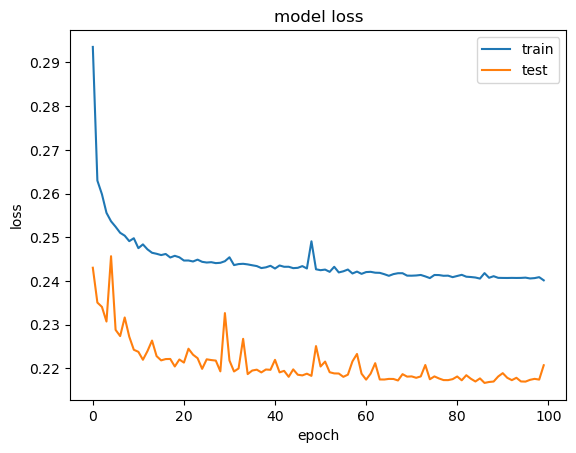

In [17]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');

### Test

In [18]:
sae_L1 = load_model('fraudSpAE_L1.pth')

In [19]:
predictions = sae_L1.predict(X_test)
mse = np.mean(np.power(X_test - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,
                        'true_class': y_test})
error_df.describe()

2671/2671 [==============================] - 6s 2ms/step


,reconstruction_error,true_class
count,85443.000000,85443.00000
mean,0.257168,0.00165
std,2.903934,0.04059
min,0.000189,0.00000
25%,0.005067,0.00000
50%,0.028511,0.00000
75%,0.092684,0.00000
max,338.308847,1.00000


In [20]:
threshold = 2.9

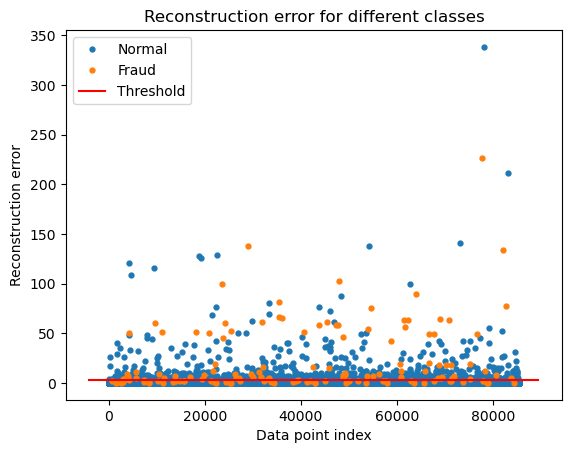

In [21]:
groups = error_df.groupby('true_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Fraud" if name == 1 else "Normal")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

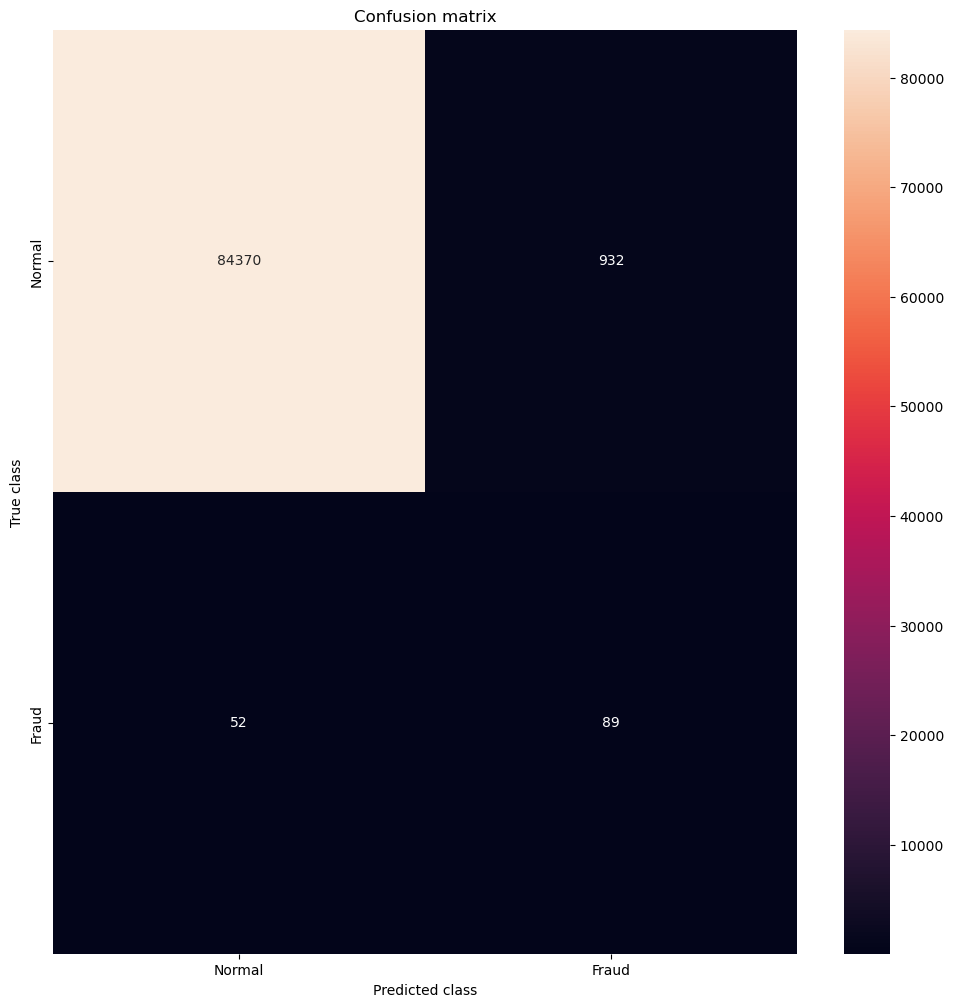

In [22]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
LABELS = ['Normal','Fraud']

y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred)
plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

### Visualize the latent space

In [23]:
inp_layer = sae_L1.input
out_layer = sae_L1.layers[2].output

L1_encoder = Model(inputs=inp_layer, outputs=out_layer)

In [24]:
L1_encoder.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28)]              0         
                                                                 
 dense (Dense)               (None, 40)                1160      
                                                                 
 dense_1 (Dense)             (None, 56)                2296      
                                                                 
Total params: 3456 (13.50 KB)
Trainable params: 3456 (13.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [38]:
encoded_df

,0,1,2,3,4,5,6,7,8,9,...,47,48,49,50,51,52,53,54,55,56
0,-0.828657,-0.913268,-0.033666,-0.702066,-0.928884,0.029755,-0.072724,0.220044,-0.040246,-0.065574,...,-0.122537,-0.158278,0.001586,-0.056493,-0.715741,-0.066198,-0.291548,0.041661,-0.034914,0.0
1,-0.738286,-0.767945,-0.018247,-0.778389,-0.996191,0.046592,0.120327,-0.096150,0.007565,-0.046303,...,-0.042509,-0.000600,0.032025,-0.072621,-0.439382,-0.254700,-0.404334,-0.030816,0.111278,0.0
2,-0.755234,-0.587730,-0.035121,-0.791622,-1.000000,-0.031110,0.081642,-0.108879,0.045561,0.051130,...,0.029061,-0.232103,-0.038695,0.050567,-0.842612,-0.059766,1.391967,-0.029249,0.087116,0.0
3,-0.826379,-0.988993,-0.002282,-0.733657,-0.988849,0.053770,-0.087407,0.220451,0.005768,-0.070869,...,-0.065509,0.155052,-0.001549,-0.190708,-0.828339,-0.230420,-0.505044,-0.007250,-0.069724,0.0
4,-0.338780,-0.838989,-0.067368,-0.654552,-1.000000,-0.028100,0.159270,0.079047,0.091464,0.107193,...,0.091836,-0.311986,-0.038772,-0.074948,-0.913019,-0.271309,1.541949,-0.073588,0.189011,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284451,-0.829229,-0.971744,-0.080648,-0.619595,-0.999990,0.022155,-0.030235,-0.053051,-0.003508,-0.005420,...,0.036902,-0.001420,-0.039615,-0.186123,-0.825955,-0.232213,-0.417795,0.028221,-0.132601,0.0
284452,-0.687182,-0.999018,-0.016358,-0.338250,-0.999728,-0.030987,-0.004050,-0.063765,0.061931,-0.042033,...,-0.044096,-0.069392,0.010537,-0.008774,-0.418106,0.016645,-0.283297,0.236479,-0.039224,0.0
284453,-0.848026,-0.973530,0.025187,-0.239552,-0.961297,-0.108714,-0.057660,-0.052554,0.013514,0.017680,...,-0.037237,-0.012371,0.029394,-0.120933,-0.827196,-0.071240,-0.419321,0.005909,-0.087121,0.0
284454,-0.340672,-0.988625,0.007564,-0.337958,-0.999634,-0.016092,-0.025243,0.028377,0.007116,-0.017947,...,0.025267,-0.111270,0.003211,-0.075607,-0.831282,-0.117134,-0.430272,-0.021938,-0.039458,0.0


2671/2671 [==============================] - 5s 2ms/step


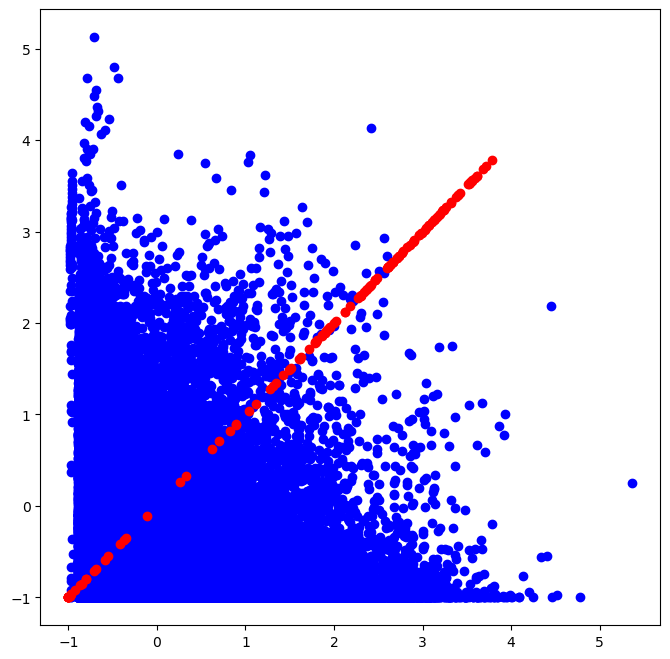

In [40]:
# hidden layer의 units가 많기 때문에 일단 0, 1번째에 대해서 latent space를 구해본다.

X_train_encoded = L1_encoder.predict(X_train)
X_test_encoded = L1_encoder.predict(X_test)

X_encoded = np.vstack((X_train_encoded, X_test_encoded))
y_main = np.hstack((np.zeros(len(X_train)), y_test))

encoded_df = pd.DataFrame(np.hstack((X_encoded, y_main[np.newaxis].transpose())))

label = L1_encoder.layers[-1].units;

plt.subplots(figsize=(8,8))
plt.scatter(encoded_df[encoded_df[label]==0][0],encoded_df[encoded_df[label]==0][1], color='blue', label='Normal')
plt.scatter(encoded_df[encoded_df[label]==1][1],encoded_df[encoded_df[label]==1][1], color='red', label='Fraud');

### Sparse AutoEncoder Model(KL Reg)

In [43]:
input_dim1 = X_train.shape[1]

input_layer1 = Input(shape=(input_dim1, ))
encoder1 = Dense(40, activation="relu")(input_layer1)

encoder1 = Dense(56, activation="relu")(encoder1)

decoder1 = Dense(40, activation='relu')(encoder1)
decoder1 = Dense(input_dim1, activation='relu')(decoder1)

sae_KL = Model(inputs=input_layer1, outputs=decoder1)

#### Def sparse_regularizer

In [44]:
from keras import backend as K
from keras.losses import mse, kld


# def kl_divergence(rho, rho_hat):
#     rho_hat = K.mean(K.sigmoid(rho_hat), axis=1)
#     rho = K.constant([rho] * K.shape(rho_hat)[0])
#     return K.sum(rho * K.log(rho / rho_hat) + (1 - rho) * K.log((1 - rho) / (1 - rho_hat)))

# def sparse_loss(rho, data):
#     values = data
#     loss = 0
#     for layer in autoencoder1.layers:
#         values = layer(values)
#         loss += kl_divergence(rho, values)
#     return loss

def custom_loss(y_true, y_pred):
    mse_loss = mse(y_true, y_pred);
    sparsity = kld(y_true, y_pred);
    beta = 0.001
    
    loss = mse_loss + beta*sparsity
    return loss;

In [45]:
epochs = 100
batch_size = 32

sae_KL.compile(optimizer='adam', loss=custom_loss, metrics=['accuracy'])
checkpointer1 = ModelCheckpoint(filepath="fraudSpAE_KL.pth", verbose=0, save_best_only=True)

### Training

In [46]:
history1 = sae_KL.fit(X_train, X_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_split=0.1,
                    callbacks=[checkpointer1]).history

Epoch 1/100
5581/5598 [============================>.] - ETA: 0s - loss: 0.7078 - accuracy: 0.7241INFO:tensorflow:Assets written to: fraudSpAE_KL.pth\assets


INFO:tensorflow:Assets written to: fraudSpAE_KL.pth\assets


5598/5598 [==============================] - 22s 4ms/step - loss: 0.7081 - accuracy: 0.7243 - val_loss: 0.6303 - val_accuracy: 0.7933
Epoch 2/100
5578/5598 [============================>.] - ETA: 0s - loss: 0.6505 - accuracy: 0.8121INFO:tensorflow:Assets written to: fraudSpAE_KL.pth\assets


INFO:tensorflow:Assets written to: fraudSpAE_KL.pth\assets


5598/5598 [==============================] - 17s 3ms/step - loss: 0.6509 - accuracy: 0.8122 - val_loss: 0.6092 - val_accuracy: 0.8388
Epoch 3/100
5598/5598 [==============================] - 16s 3ms/step - loss: 0.6371 - accuracy: 0.8394 - val_loss: 0.6146 - val_accuracy: 0.7689
Epoch 4/100
5598/5598 [==============================] - 17s 3ms/step - loss: 0.6257 - accuracy: 0.8725 - val_loss: 0.6488 - val_accuracy: 0.7625
Epoch 5/100
5588/5598 [============================>.] - ETA: 0s - loss: 0.6282 - accuracy: 0.8680INFO:tensorflow:Assets written to: fraudSpAE_KL.pth\assets


INFO:tensorflow:Assets written to: fraudSpAE_KL.pth\assets


5598/5598 [==============================] - 17s 3ms/step - loss: 0.6280 - accuracy: 0.8681 - val_loss: 0.5956 - val_accuracy: 0.8988
Epoch 6/100
5593/5598 [============================>.] - ETA: 0s - loss: 0.6213 - accuracy: 0.8884INFO:tensorflow:Assets written to: fraudSpAE_KL.pth\assets


INFO:tensorflow:Assets written to: fraudSpAE_KL.pth\assets


5598/5598 [==============================] - 17s 3ms/step - loss: 0.6213 - accuracy: 0.8885 - val_loss: 0.5846 - val_accuracy: 0.9224
Epoch 7/100
5579/5598 [============================>.] - ETA: 0s - loss: 0.6167 - accuracy: 0.9160INFO:tensorflow:Assets written to: fraudSpAE_KL.pth\assets


INFO:tensorflow:Assets written to: fraudSpAE_KL.pth\assets


5598/5598 [==============================] - 17s 3ms/step - loss: 0.6165 - accuracy: 0.9161 - val_loss: 0.5843 - val_accuracy: 0.9460
Epoch 8/100
5598/5598 [==============================] - 16s 3ms/step - loss: 0.6285 - accuracy: 0.9002 - val_loss: 0.6943 - val_accuracy: 0.6559
Epoch 9/100
5598/5598 [==============================] - 16s 3ms/step - loss: 0.6286 - accuracy: 0.8701 - val_loss: 0.5853 - val_accuracy: 0.9234
Epoch 10/100
5598/5598 [==============================] - 20s 4ms/step - loss: 0.6159 - accuracy: 0.9193 - val_loss: 0.5864 - val_accuracy: 0.9376
Epoch 11/100
5598/5598 [==============================] - 17s 3ms/step - loss: 0.6146 - accuracy: 0.9272 - val_loss: 0.5885 - val_accuracy: 0.9444
Epoch 12/100
5598/5598 [==============================] - 18s 3ms/step - loss: 0.6196 - accuracy: 0.9137 - val_loss: 0.5963 - val_accuracy: 0.9132
Epoch 13/100
5592/5598 [============================>.] - ETA: 0s - loss: 0.6141 - accuracy: 0.9285INFO:tensorflow:Assets written to:

INFO:tensorflow:Assets written to: fraudSpAE_KL.pth\assets


5598/5598 [==============================] - 18s 3ms/step - loss: 0.6143 - accuracy: 0.9286 - val_loss: 0.5830 - val_accuracy: 0.9517
Epoch 14/100
5598/5598 [==============================] - 17s 3ms/step - loss: 0.6200 - accuracy: 0.9055 - val_loss: 0.5831 - val_accuracy: 0.9502
Epoch 15/100
5598/5598 [==============================] - 17s 3ms/step - loss: 0.6146 - accuracy: 0.9262 - val_loss: 0.5993 - val_accuracy: 0.8522
Epoch 16/100
5598/5598 [==============================] - 17s 3ms/step - loss: 0.6191 - accuracy: 0.9132 - val_loss: 0.5836 - val_accuracy: 0.9426
Epoch 17/100
5598/5598 [==============================] - 17s 3ms/step - loss: 0.6157 - accuracy: 0.9213 - val_loss: 0.6040 - val_accuracy: 0.8837
Epoch 18/100
5598/5598 [==============================] - 17s 3ms/step - loss: 0.6121 - accuracy: 0.9355 - val_loss: 0.5838 - val_accuracy: 0.9460
Epoch 19/100
5598/5598 [==============================] - 19s 3ms/step - loss: 0.6193 - accuracy: 0.9083 - val_loss: 0.5837 - val_a

INFO:tensorflow:Assets written to: fraudSpAE_KL.pth\assets


5598/5598 [==============================] - 20s 4ms/step - loss: 0.6124 - accuracy: 0.9342 - val_loss: 0.5829 - val_accuracy: 0.9475
Epoch 26/100
5598/5598 [==============================] - 17s 3ms/step - loss: 0.6117 - accuracy: 0.9402 - val_loss: 0.5831 - val_accuracy: 0.9603
Epoch 27/100
5584/5598 [============================>.] - ETA: 0s - loss: 0.6111 - accuracy: 0.9401INFO:tensorflow:Assets written to: fraudSpAE_KL.pth\assets


INFO:tensorflow:Assets written to: fraudSpAE_KL.pth\assets


5598/5598 [==============================] - 18s 3ms/step - loss: 0.6112 - accuracy: 0.9402 - val_loss: 0.5826 - val_accuracy: 0.9574
Epoch 28/100
5598/5598 [==============================] - 17s 3ms/step - loss: 0.6116 - accuracy: 0.9373 - val_loss: 0.5828 - val_accuracy: 0.9547
Epoch 29/100
5598/5598 [==============================] - 17s 3ms/step - loss: 0.6124 - accuracy: 0.9320 - val_loss: 0.5849 - val_accuracy: 0.9194
Epoch 30/100
5592/5598 [============================>.] - ETA: 0s - loss: 0.6102 - accuracy: 0.9478INFO:tensorflow:Assets written to: fraudSpAE_KL.pth\assets


INFO:tensorflow:Assets written to: fraudSpAE_KL.pth\assets


5598/5598 [==============================] - 19s 3ms/step - loss: 0.6101 - accuracy: 0.9478 - val_loss: 0.5823 - val_accuracy: 0.9591
Epoch 31/100
5598/5598 [==============================] - 17s 3ms/step - loss: 0.6112 - accuracy: 0.9441 - val_loss: 0.6155 - val_accuracy: 0.8318
Epoch 32/100
5598/5598 [==============================] - 18s 3ms/step - loss: 0.6112 - accuracy: 0.9425 - val_loss: 0.5870 - val_accuracy: 0.9282
Epoch 33/100
5582/5598 [============================>.] - ETA: 0s - loss: 0.6104 - accuracy: 0.9475INFO:tensorflow:Assets written to: fraudSpAE_KL.pth\assets


INFO:tensorflow:Assets written to: fraudSpAE_KL.pth\assets


5598/5598 [==============================] - 20s 4ms/step - loss: 0.6103 - accuracy: 0.9475 - val_loss: 0.5820 - val_accuracy: 0.9663
Epoch 34/100
5598/5598 [==============================] - 15s 3ms/step - loss: 0.6100 - accuracy: 0.9494 - val_loss: 0.5821 - val_accuracy: 0.9671
Epoch 35/100
5598/5598 [==============================] - 15s 3ms/step - loss: 0.6101 - accuracy: 0.9470 - val_loss: 0.5829 - val_accuracy: 0.9413
Epoch 36/100
5598/5598 [==============================] - 15s 3ms/step - loss: 0.6090 - accuracy: 0.9558 - val_loss: 0.5821 - val_accuracy: 0.9664
Epoch 37/100
5598/5598 [==============================] - 15s 3ms/step - loss: 0.6106 - accuracy: 0.9456 - val_loss: 0.5825 - val_accuracy: 0.9548
Epoch 38/100
5581/5598 [============================>.] - ETA: 0s - loss: 0.6090 - accuracy: 0.9565INFO:tensorflow:Assets written to: fraudSpAE_KL.pth\assets


INFO:tensorflow:Assets written to: fraudSpAE_KL.pth\assets


5598/5598 [==============================] - 17s 3ms/step - loss: 0.6089 - accuracy: 0.9565 - val_loss: 0.5820 - val_accuracy: 0.9677
Epoch 39/100
5598/5598 [==============================] - 15s 3ms/step - loss: 0.6118 - accuracy: 0.9391 - val_loss: 0.5821 - val_accuracy: 0.9608
Epoch 40/100
5598/5598 [==============================] - 15s 3ms/step - loss: 0.6097 - accuracy: 0.9514 - val_loss: 0.5820 - val_accuracy: 0.9666
Epoch 41/100
5598/5598 [==============================] - 15s 3ms/step - loss: 0.6092 - accuracy: 0.9554 - val_loss: 0.5826 - val_accuracy: 0.9616
Epoch 42/100
5598/5598 [==============================] - 18s 3ms/step - loss: 0.6104 - accuracy: 0.9493 - val_loss: 0.5846 - val_accuracy: 0.9446
Epoch 43/100
5594/5598 [============================>.] - ETA: 0s - loss: 0.6093 - accuracy: 0.9544INFO:tensorflow:Assets written to: fraudSpAE_KL.pth\assets


INFO:tensorflow:Assets written to: fraudSpAE_KL.pth\assets


5598/5598 [==============================] - 21s 4ms/step - loss: 0.6092 - accuracy: 0.9544 - val_loss: 0.5820 - val_accuracy: 0.9710
Epoch 44/100
5598/5598 [==============================] - 19s 3ms/step - loss: 0.6092 - accuracy: 0.9549 - val_loss: 0.5824 - val_accuracy: 0.9584
Epoch 45/100
5598/5598 [==============================] - 19s 3ms/step - loss: 0.6095 - accuracy: 0.9539 - val_loss: 0.5828 - val_accuracy: 0.9553
Epoch 46/100
5598/5598 [==============================] - 17s 3ms/step - loss: 0.6091 - accuracy: 0.9553 - val_loss: 0.5869 - val_accuracy: 0.9308
Epoch 47/100
5598/5598 [==============================] - 18s 3ms/step - loss: 0.6097 - accuracy: 0.9517 - val_loss: 0.5826 - val_accuracy: 0.9532
Epoch 48/100
5598/5598 [==============================] - 17s 3ms/step - loss: 0.6098 - accuracy: 0.9512 - val_loss: 0.5822 - val_accuracy: 0.9637
Epoch 49/100
5598/5598 [==============================] - 17s 3ms/step - loss: 0.6095 - accuracy: 0.9550 - val_loss: 0.5870 - val_a

INFO:tensorflow:Assets written to: fraudSpAE_KL.pth\assets


5598/5598 [==============================] - 27s 5ms/step - loss: 0.6088 - accuracy: 0.9593 - val_loss: 0.5819 - val_accuracy: 0.9718
Epoch 71/100
5598/5598 [==============================] - 23s 4ms/step - loss: 0.6099 - accuracy: 0.9503 - val_loss: 0.5826 - val_accuracy: 0.9560
Epoch 72/100
5598/5598 [==============================] - 24s 4ms/step - loss: 0.6102 - accuracy: 0.9490 - val_loss: 0.5820 - val_accuracy: 0.9670
Epoch 73/100
5598/5598 [==============================] - 21s 4ms/step - loss: 0.6112 - accuracy: 0.9473 - val_loss: 0.5822 - val_accuracy: 0.9665
Epoch 74/100
5598/5598 [==============================] - 21s 4ms/step - loss: 0.6091 - accuracy: 0.9545 - val_loss: 0.5821 - val_accuracy: 0.9651
Epoch 75/100
5598/5598 [==============================] - 21s 4ms/step - loss: 0.6101 - accuracy: 0.9519 - val_loss: 0.5823 - val_accuracy: 0.9593
Epoch 76/100
5598/5598 [==============================] - 21s 4ms/step - loss: 0.6113 - accuracy: 0.9452 - val_loss: 0.5823 - val_a

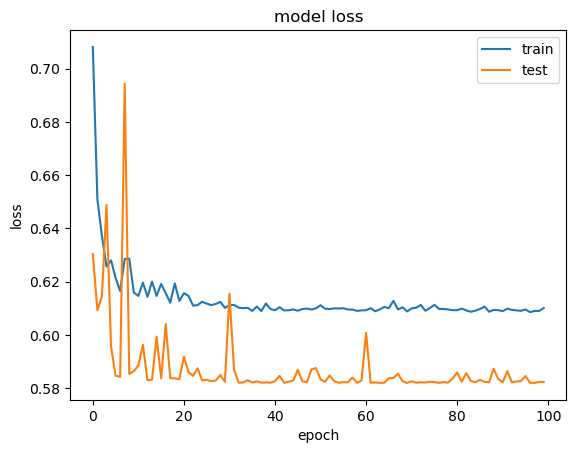

In [47]:
plt.plot(history1['loss'])
plt.plot(history1['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');

### Test

In [48]:
with keras.utils.custom_object_scope({"custom_loss": 'mse'}):
    sae_KL = keras.models.load_model('fraudSpAE_KL.pth')

In [49]:
KL_encode = sae_KL.predict(X_test)
mse1 = np.mean(np.power(X_test - KL_encode, 2), axis=1)
error_df1 = pd.DataFrame({'reconstruction_error': mse1,
                        'true_class': y_test})
error_df1.describe()

2671/2671 [==============================] - 6s 2ms/step


,reconstruction_error,true_class
count,85443.000000,85443.00000
mean,0.622587,0.00165
std,3.333313,0.04059
min,0.021824,0.00000
25%,0.190058,0.00000
50%,0.312528,0.00000
75%,0.515002,0.00000
max,392.823928,1.00000


In [50]:
threshold1 = 2.9

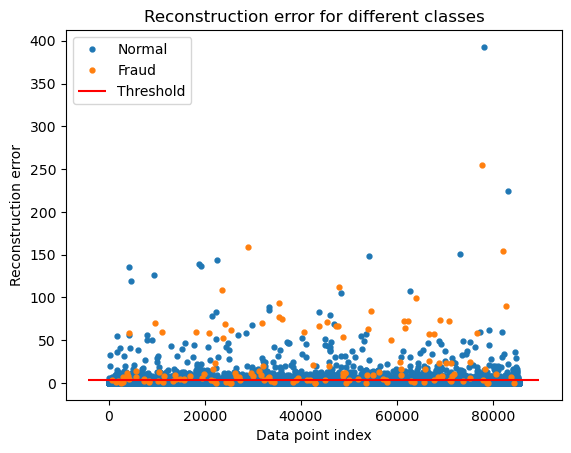

In [51]:
groups = error_df1.groupby('true_class')
fig1, ax1 = plt.subplots()

for name, group in groups:
    ax1.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Fraud" if name == 1 else "Normal")
ax1.hlines(threshold1, ax1.get_xlim()[0], ax1.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax1.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

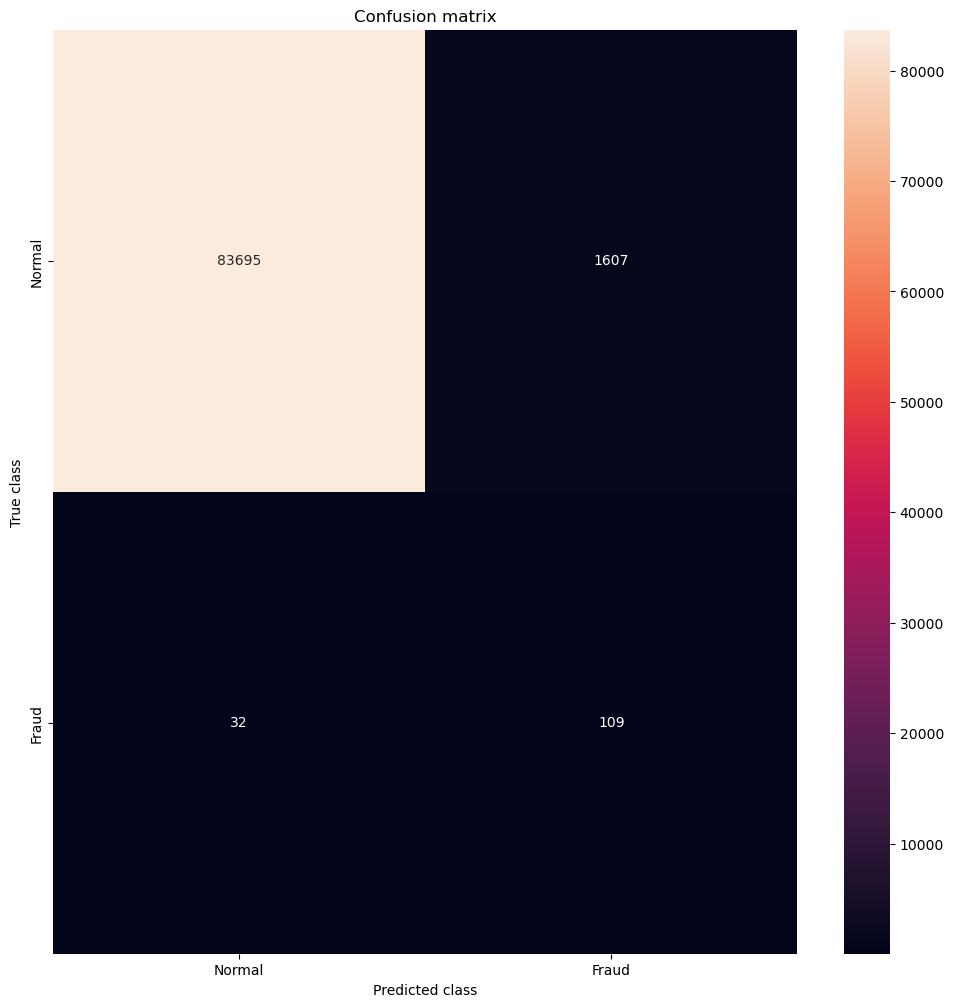

In [52]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
LABELS = ['Normal','Fraud']

y_pred1 = [1 if e > threshold1 else 0 for e in error_df1.reconstruction_error.values]
conf_matrix1 = confusion_matrix(error_df1.true_class, y_pred1)
plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix1, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

### Visualize the latent space

In [53]:
inp_layer1 = KL_encode.input
out_layer1 = KL_encode.layers[2].output

KL_encoder = Model(inputs=inp_layer1, outputs=out_layer1)

AttributeError: 'numpy.ndarray' object has no attribute 'input'

In [ ]:
KL_encoder.summary()

In [ ]:
X_train_encoded = KL_encoder.predict(X_train)
X_test_encoded = KL_encoder.predict(X_test)

X_encoded = np.vstack((X_train_encoded, X_test_encoded))
y_main = np.hstack((np.zeros(len(X_train)), y_test))

encoded_df = pd.DataFrame(np.hstack((X_encoded, y_main[np.newaxis].transpose())))

label = KL_encoder.layers[-1].units;

plt.subplots(figsize=(8,8))
plt.scatter(encoded_df[encoded_df[label]==0][0],encoded_df[encoded_df[label]==0][1], color='blue', label='Normal')
plt.scatter(encoded_df[encoded_df[label]==1][1],encoded_df[encoded_df[label]==1][1], color='red', label='Fraud');